<a href="https://colab.research.google.com/github/PabloJRW/TinyML-sineFunction/blob/main/TinyML_Sin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [152]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

In [153]:
np.random.seed(12)
tf.random.set_seed(12)

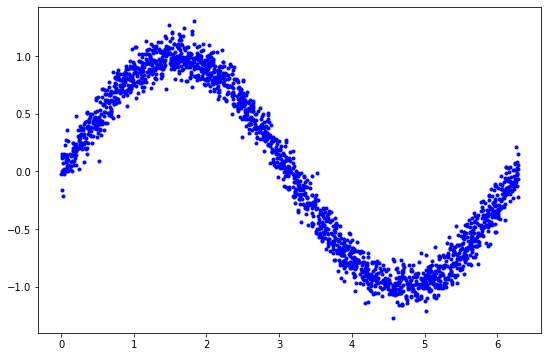

In [154]:

x_values = np.random.uniform(low=0, high=2*math.pi, size=2000)

# Shuffle the values

# Calculate the corresponding sine values
y_values = np.sin(x_values)
# Adding noise
y_values += 0.1 * np.random.randn(*y_values.shape)

# 
plt.figure(figsize=(9,6))
plt.plot(x_values, y_values, 'b.')
plt.show()

In [155]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(x_values, y_values, test_size=0.3, random_state=24)

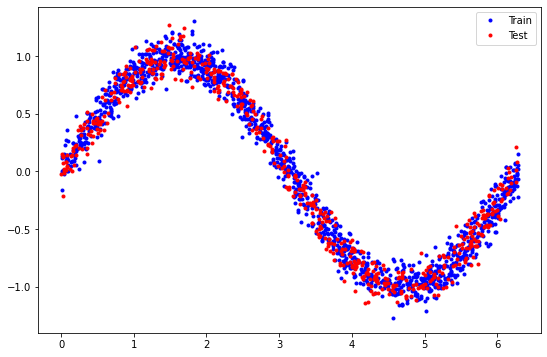

In [156]:
# Plot the data in each data set
plt.figure(figsize=(9,6))
plt.plot(X_train, y_train, 'b.', label='Train')
plt.plot(X_test, y_test, 'r.', label='Test')
plt.legend()
plt.show()

In [157]:
def get_new_model():
  model = Sequential()
  model.add(Dense(100, activation='relu', input_shape=(1, )))
  model.add(Dense(100, activation='relu'))
  model.add(Dense(1))
  return model


optimizers = {'SGD':SGD, 'Adam':Adam, 'RMSprop':RMSprop}
lr_to_test = [0.000001, 0.0001, 0.001, 0.01, 1]

results = list()
for optimizer_k, optimizer_v in optimizers.items():
  for lr in lr_to_test:
      # Build new model to test, unaffected by previous models
      model = get_new_model()
      # learning rate: my_optimizer
      my_optimizer = optimizer_v(learning_rate=lr)
      # compiling
      model.compile(optimizer=my_optimizer, loss='mse', metrics=['mae'])
     # Fit the model
      history = model.fit(X_train, y_train, verbose=False)

      results.append([optimizer_k, lr, history.history])

df = pd.DataFrame(results, columns=['optimizer', 'lr', 'history'])
df['loss'] = df['history'].apply(lambda x: x['loss'][0]).round(2)
df['mae'] = df['history'].apply(lambda x: x['mae'][0]).round(2)
df.drop('history', axis=1, inplace=True)
df.sort_values(by='mae')[:5]

,optimizer,lr,loss,mae
8,Adam,0.0100,0.29,0.44
12,RMSprop,0.0010,0.33,0.49
7,Adam,0.0010,0.38,0.53
3,SGD,0.0100,0.38,0.54
6,Adam,0.0001,0.44,0.57


In [158]:
# Training the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32,
                    validation_split=0.2)

Epoch 1/100
35/35 [==============================] - 0s 7ms/step - loss: 522.7110 - mae: 11.9070 - val_loss: 91.0485 - val_mae: 8.8733
Epoch 2/100
35/35 [==============================] - 0s 4ms/step - loss: 284.1670 - mae: 10.0078 - val_loss: 604.0434 - val_mae: 24.5555
Epoch 3/100
35/35 [==============================] - 0s 5ms/step - loss: 142.0969 - mae: 5.9006 - val_loss: 4.1701 - val_mae: 1.9127
Epoch 4/100
35/35 [==============================] - 0s 4ms/step - loss: 11.0996 - mae: 1.8134 - val_loss: 0.5899 - val_mae: 0.6492
Epoch 5/100
35/35 [==============================] - 0s 4ms/step - loss: 2.1085 - mae: 1.0422 - val_loss: 1.8988 - val_mae: 1.1792
Epoch 6/100
35/35 [==============================] - 0s 4ms/step - loss: 0.7954 - mae: 0.7409 - val_loss: 0.8100 - val_mae: 0.7234
Epoch 7/100
35/35 [==============================] - 0s 4ms/step - loss: 0.7713 - mae: 0.7262 - val_loss: 1.0879 - val_mae: 0.8264
Epoch 8/100
35/35 [==============================] - 0s 5ms/step - los

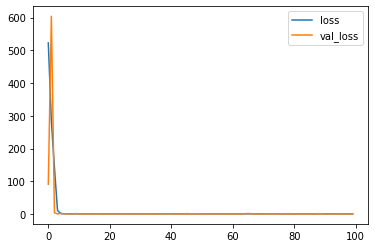

In [159]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.legend()
plt.show()

In [160]:
model.evaluate(X_test, y_test)

19/19 [==============================] - 0s 2ms/step - loss: 0.8056 - mae: 0.7457


[0.8055731654167175, 0.7457239031791687]

In [161]:

# Predictions
predictions = model.predict(X_train)

44/44 [==============================] - 0s 2ms/step


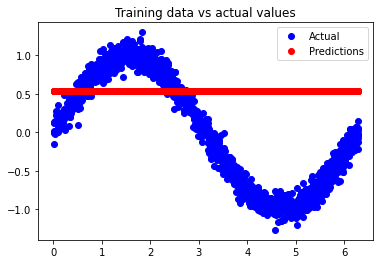

In [162]:
plt.clf()
plt.title("Training data vs actual values")
plt.plot(X_train, y_train, 'bo', label='Actual')
plt.plot(X_train, predictions, 'ro', label='Predictions')
plt.legend()
plt.show()

In [163]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model 
with open("sine_model.tflite", "wb") as f:
  f.write(tflite_model)

#Convert the model to Tensorflow Lite format with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

def representative_dataset_generator():
  for value in X_test:
    yield [np.array(value, dtype=np.float32)]

converter.representative_dataset = representative_dataset_generator

# Convert the model
tflite_model = converter.convert()

# Save the optimized model 
with open("sine_model_quantized.tflite",  "wb") as fq:
  fq.write(tflite_model)

/usr/local/lib/python3.7/dist-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [164]:
sine_model = tf.lite.Interpreter('sine_model.tflite')
sine_model_quantized = tf.lite.Interpreter('sine_model_quantized.tflite')

sine_model.allocate_tensors()
sine_model_quantized.allocate_tensors()

sine_model_input_index = sine_model.get_input_details()[0]["index"]
sine_model_output_index = sine_model.get_output_details()[0]["index"]
sine_model_quantized_input_index = sine_model_quantized.get_input_details()[0]["index"]
sine_model_quantized_output_index = sine_model_quantized.get_output_details()[0]["index"]

sine_model_predictions = []
sine_model_quantized_predictions = []

for x_value in X_test:
  x_value_tensor = tf.convert_to_tensor([[x_value]], dtype=np.float32)
  sine_model.set_tensor(sine_model_input_index, x_value_tensor)
  sine_model.invoke()

  sine_model_predictions.append(
      sine_model.get_tensor(sine_model_output_index)[0])
  
  sine_model_quantized.set_tensor(sine_model_quantized_input_index, x_value_tensor)
  sine_model_quantized.invoke()
  sine_model_quantized_predictions.append(
      sine_model_quantized.get_tensor(sine_model_quantized_output_index)[0])